<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../B/B.html"><img src="../data/B_nav.png" width="100"  style="float:right;" alt="C2"></a>
<h1>Sonification</h1> 
</div>

<br/>

<p>
In this notebook, we introduce some tools that can be used for the sonification of feature representations and annotations.  
</p> 

## Introduction


In the FMP notebooks, we use a multitude of figures with concrete examples to communicate the main ideas of music processing approaches. In particular, the **visualization** of feature representations such as [spectrograms](../C2/C2_STFT-Basic.html), [chromagrams](../C3/C3S1_SpecLogFreq-Chromagram.html), or [tempograms](../C6/C6S2_TempogramFourier.html) not only deepens the understanding of signal processing concepts, but also provides valuable insights into musical and acoustic properties of the underlying audio signals. Furthermore, the [combined visualization of extracted features and reference annotations](../B/B_Annotations.html) allows for an in-depth inspection of algorithmic approaches on a piece-wise level. Such qualitative evaluations are, besides [quantitative evaluations based on suitable metrics](../C4/C4S5_Evaluation.html),  essential for understanding the benefits and limitations of algorithmic approaches as well as the suitability and validity of the underlying model assumptions. 

As an alternative or complement to **data visualization**, one may also use **data sonification** as a means for providing acoustic feedback on the nature of extracted or annotated information. This particularly holds for music, where humans are trained to perceive even slight deviations in frequency and timing of sound events. For example, one can immediately recognize small rhythmic deviations when listing to a pulse track sonified in form a sequence of click sounds. In this notebook, we introduce three sonification methods that are helpful in analyzing annotations as well as audio features extracted from a music recording. 

* **Sonification of time positions** using click sounds. This technique is useful for inspecting the accuracy of [onset, beat, and measure positions](../C6/C6S1_OnsetDetection.html). 
* **Sonification of frequency trajectories** using sinusoidal models. This method yields insights for tasks such as [melody estimation](../C8/C8S2_FundFreqTracking.html) or [singing voice separation](../C8/C8S2_MelodyExtractSep.html).
* **Sonification of chroma features** using [Shepard tones](../C1/C1S1_ChromaShepard.html). This technique provides an acoustic representation of the information encoded by [chromagrams](../C3/C3S1_SpecLogFreq-Chromagram.html).

Obviously, there are many more ways for sonifying acoustic properties of music signals. In particular, a superposition of the original music signal and a suitable sonification of specific features often leads to fascinating and surprising insights.

## Sonification of Time Positions

In the first scenario, we assume that we are given a music recording as well as a list of time positions that indicate the presence of certain musical events. For example, the musical events may refer to [onset positions](../C6/C6S1_OnsetDetection.html) of certain notes, to [beat positions](../C6/C6S2_TempoBeat.html), or [structural boundaries](../C4/C4S1_MusicStructureGeneral.html) between musical parts. Then, the goal of sonification is to generate a succinct acoustic stimulus at each of the time positions, thus giving the listener a precise temporal feedback. Ideally, the stimuli should be perceivable also when being superimposed with the original music recording. Often the time positions are further classified according to different categories (e.g., downbeat and upbeat positions). Therefore, it is useful to have a "coloration" method for generating distinguishable stimuli that can easily be associated with the different categories.

The [LibROSA](https://librosa.org/doc/latest/index.html) python package provides the function [`librosa.clicks`](https://librosa.org/doc/latest/generated/librosa.clicks.html?highlight=click#librosa.clicks) for generating a family of distinguishable stimuli in form of click sounds that can be placed at the time positions specified. The function allows for adjusting the frequency (with a default of $1000~\mathrm{Hz}$) as well as the duration (with a default of $100~\mathrm{ms}$) of the click signal. 

As an example, we consider a short excerpt of an orchestra recording of the Waltz No. 2 from the Suite for Variety Orchestra No. 1 by Dimitri Shostakovich. In the annotation file, we have marked the beat positions (given in seconds). Being in the $3/4$ meter, every third beat corresponds to a downbeat or measure position. In the following code cell, we generate a sonification, where we use a long click sound of low frequency to indicate measure positions and a short click sound of high frequency to indicate beat positions. While, in the visualization, the annotated time positions are superimposed with the waveform plot, the generated click sounds are superimposed with the original music recording.


<img src="../data/B/FMP_B_Sonify_Beat_Shostakovich_Waltz.png" width="500px" align="left" alt="FMP_B_Sonify_Beat_Shostakovich_Waltz.png">

<br clear="all" />

<audio style="width: 300px;" src="../data/B/FMP_B_Sonify_Beat_Shostakovich_Waltz.mp3" type="audio/mpeg" controls="controls"></audio>

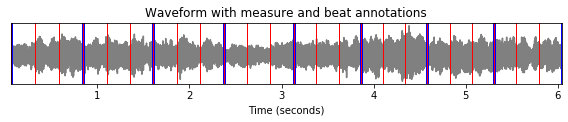

In [1]:
import os
import sys
import numpy as np
import librosa
import pandas as pd
from matplotlib import pyplot as plt
import IPython.display as ipd

sys.path.append('..')
import libfmp.b
import libfmp.c8

%matplotlib inline

# Load audio and read beat annotations
fn_wav = os.path.join('..', 'data', 'B', 'FMP_B_Sonify_Beat_Shostakovich_Waltz.wav')
fn_ann = os.path.join('..', 'data', 'B', 'FMP_B_Sonify_Beat_Shostakovich_Waltz.csv')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 
df = pd.read_csv(fn_ann, sep=';', keep_default_na=False, header=None)
beat_sec = df.values
meas_sec = beat_sec[::3]
ann_beat = [(pos, 'beat') for pos in beat_sec]
ann_meas = [(pos, 'measure') for pos in meas_sec]
    
# Plot waveform and annotations
label_keys = {'measure': {'linewidth': 3, 'color': 'b'},
              'beat': {'linewidth': 1, 'color': 'r'}}
title = 'Waveform with measure and beat annotations'
fig, ax, line = libfmp.b.plot_signal(x, Fs, title=title, figsize=(8, 1.8))
libfmp.b.plot_annotation_line(ann_meas+ann_beat, ax=ax, label_keys=label_keys)
plt.tight_layout()

plt.show()

# Sonify beat and measure annotations
x_beat = librosa.clicks(beat_sec, sr=Fs, click_freq=2000, 
                        length=len(x), click_duration=0.1)
x_meas = librosa.clicks(meas_sec, sr=Fs, click_freq=400, 
                        length=len(x), click_duration=0.3)
ipd.display(ipd.Audio(x + x_beat + x_meas, rate=Fs))

## Sonification of Frequency Trajectories

When asked to describe a specific song, we are often able to sing or hum the [main melody](../C8/C8S2_MelodyExtractSep.html),  which may be loosely defined as a linear succession of musical tones expressing a particular musical idea. Given a music recording (rather than a musical score), the melody corresponds to a sequence of [**fundamental frequency values**](../C8/C8S2_FundFreqTracking.html) (also called **F0-values**) of the tones' pitches. In real performances, such sequences often form complex time&ndash;frequency patterns referred to as a **frequency trajectories**. These trajectories may comprise continuous frequency glides from one to the next note ([glissando](../C8/C8S2_MelodyExtractSep.html)) or frequency modulations ([vibrato](../C1/C1S3_Timbre.html)). As an example, we consider a short excerpt of an aria from the opera "Der Freischütz" by Carl Maria von Weber. In the score representation, the main melody is notated in a separate staff line underlaid with lyrics. 

<img src="../data/B/FMP_B_Sonify_F0_Weber_Freischuetz.png" width="300px" align="left" alt="FMP_C8_F10a">

<br clear="all" />

<audio style="width: 300px;" src="../data/B/FMP_B_Sonify_F0_Weber_Freischuetz.mp3" type="audio/mpeg" controls="controls"></audio>

In the performance by a soprano singer, the melody corresponds to an F0-trajectory, which we visualize in the following code cell along with the recording's waveform. Furthermore, we use  the function [`libfmp.c8.sonify_trajectory_with_sinusoid`](../C8/C8S2_FundFreqTracking.html) to sonify the F0-trajectory using a sinusoidal synthesizer. The sonification is provided in three different formats:

* As mono signal. 
* As mono signal superimposed with the original recording.
* As stereo signal with the F0-sonification in the right and the original recording in the left channel.

The sonification nicely shows that, as opposed to the notated symbolic representation, the singer smoothly connects some of the notes. Also, one can notice rather pronounced frequency modulations due to vibrato. The superposition with the original recording yields a convenient way to perceptually evaluate the temporal and spectral accuracy of the extracted F0-trajectory. 


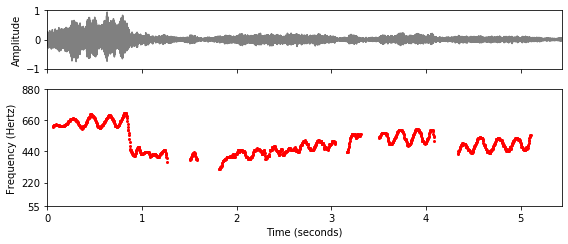

F0 sonification (mono)


F0 sonification superimposed with original recording (mono)


F0 sonification (right channel), original recording (left channel)


In [2]:
# Load audio and read F0-trajectory annotations
fn_wav = os.path.join('..', 'data', 'B', 'FMP_B_Sonify_F0_Weber_Freischuetz.wav')
fn_traj = os.path.join('..', 'data', 'B', 'FMP_B_Sonify_F0_Weber_Freischuetz.csv')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)
traj_df = libfmp.b.read_csv(fn_traj)
traj = traj_df.values

# Plot waveform and F0-trajectory annotations
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]}, sharex=True, figsize=(8, 3.5))
libfmp.b.plot_signal(x, Fs, ax=ax[0], xlabel='')
ax[0].set_ylim((-1,1))
ax[0].set_ylabel('Amplitude')
traj_plot = traj[traj[:, 1] > 0]
ax[1].plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='')
ax[1].set_ylim((55, 880))
ax[1].set_yticks([55, 220, 440, 660, 880])
ax[1].set_xlim((0, len(x) / Fs))
ax[1].set_ylabel('Frequency (Hertz)')
ax[1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

# Sonify F0 trajectory
x_traj_mono = libfmp.c8.sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11, amplitude=0.6)
# left: x, right: sonification
x_traj_stereo = np.vstack((x.reshape(1, -1), x_traj_mono.reshape(1, -1)))  
print('F0 sonification (mono)')
ipd.display(ipd.Audio(x_traj_mono, rate=Fs))
print('F0 sonification superimposed with original recording (mono)')
ipd.display(ipd.Audio( (x_traj_mono+x) / 2, rate=Fs))
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

## Sonification of Pitch- and Chroma-Based Representations

In our third scenario, we introduce some functions for sonifying pitch- and chroma-based information. As an example, we consider an excerpt of the song "Frühlingstraum" ("Dream of Spring"), which is the eleventh song of the song cycle "Winterreise" (D. 911, "Winter Journey") for voice and piano by Franz Schubert. 

<img src="../data/B/FMP_B_Sonify_Pitch_Schubert_D911-11_D.png" width="600px" align="left" alt="FMP_C8_F10a">

<br clear="all" />

<audio style="width: 300px;" src="../data/B/FMP_B_Sonify_Pitch_Schubert_D911-11_SC06.mp3" type="audio/mpeg" controls="controls"></audio>

We start with a symbolic score representation (given as [CSV file](../C1/C1S2_CSV.html)), where each note is specified by a start, duration, pitch, and other parameters. Furthermore, the start and duration parameters (given in seconds) are aligned to run synchronously to the music recording. In the following code cell, we visualize the synchronized score information in form of a [piano roll representation](../C1/C1S2_PianoRoll.html). Furthermore, we apply a function that uses a simple **sinusoidal model (with harmonics)** to sonify the symbolic note information. The result is provided as mono signal as well as stereo signal (with the sonification in one and the original recording in the other channel).

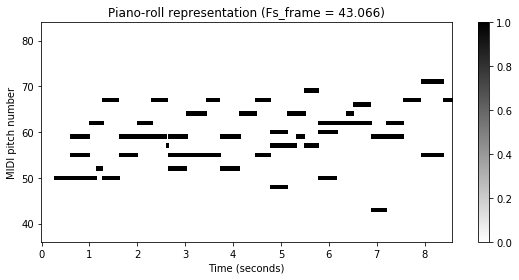

Sonification of piano-roll representation (mono):


Sonification of piano-roll representation and original audio (stereo):


In [3]:
# Load audio and read in pitch annotations
fn_wav = os.path.join('..', 'data', 'B', 'FMP_B_Sonify_Pitch_Schubert_D911-11_SC06.wav')
fn_ann = os.path.join('..', 'data', 'B', 'FMP_B_Sonify_Pitch_Schubert_D911-11_SC06.csv')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)
x_dur = len(x) / Fs
note_list_df = pd.read_csv(fn_ann, sep=';')
#ipd.display(ipd.HTML(note_list_df[0:10].to_html()))
note_list = [[start, dur, pitch, vel, ins] for i, 
             (start, dur, pitch, vel, ins) in note_list_df.iterrows()]
# note_list = libfmp.c1.csv_to_list(fn_ann)

# Piano-roll representation from annotations
H = 512
num_frames = int(len(x) / H)
Fs_frame = Fs / H
X_ann, F_coef_MIDI = libfmp.b.list_to_pitch_activations(note_list, num_frames, Fs_frame)
title = 'Piano-roll representation (Fs_frame = %.3f)' % Fs_frame
libfmp.b.plot_matrix(X_ann, Fs=Fs_frame, F_coef=F_coef_MIDI,  ylabel='MIDI pitch number',
                     title=title, figsize=(8, 4))
plt.ylim([36, 84])
plt.show()

# Sonification
harmonics = [1, 1/2, 1/3, 1/4, 1/5]
fading_msec = 0.5
x_pitch_ann, x_pitch_ann_stereo = \
    libfmp.b.sonify_pitch_activations_with_signal(X_ann, x, Fs_frame, Fs,
                                                  fading_msec=fading_msec, 
                                                  harmonics_weights=harmonics)
print('Sonification of piano-roll representation (mono):')
ipd.display(ipd.Audio(x_pitch_ann, rate=Fs) )
print('Sonification of piano-roll representation and original audio (stereo):')
ipd.display(ipd.Audio(x_pitch_ann_stereo, rate=Fs) )

Next, we introduce a sonification of [chroma-based representations](../C3/C3S1_SpecLogFreq-Chromagram.html), where pitch bands that spectrally differ by one or several octaves are combined to from a single chroma band. Such representations, which play an important role throughout the FMP notebooks, capture tonal information related to harmony and melody while showing a high degree of invariance with respect to timbre and instrumentation. For the sonification, we use [Shepard tones](../C1/C1S1_ChromaShepard.html), which are suitably weighted superpositions of sinusoids separated by octaves. Intuitively, Shepard tones can be seen as the acoustic analog to the chroma values. In the following code cell, we generate a chroma-based representation of our pitch-based piano roll representation. The sonfication result is again provided as mono and stereo signal. 

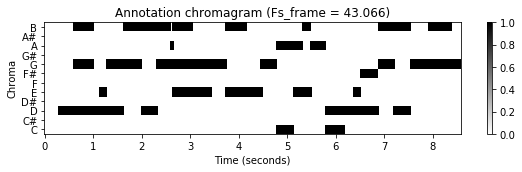

Sonification of chroma-based respresentation (mono):


Sonification of chroma-based respresentation and original audio (stereo):


In [4]:
# Chromgram from annotations
H = 512
num_frames = int(len(x) / H)
Fs_frame = Fs / H
C_ann = libfmp.b.list_to_chromagram(note_list, num_frames, Fs_frame)
title = 'Annotation chromagram (Fs_frame = %.3f)' % Fs_frame
libfmp.b.plot_chromagram(C_ann, Fs=Fs_frame, title=title, figsize=(8, 2.5))
plt.show()

# Sonification
x_chroma_ann, x_chroma_ann_stereo = libfmp.b.sonify_chromagram_with_signal(C_ann, x, Fs_frame, Fs)
print('Sonification of chroma-based respresentation (mono):')
ipd.display(ipd.Audio(x_chroma_ann, rate=Fs))
print('Sonification of chroma-based respresentation and original audio (stereo):')
ipd.display(ipd.Audio(x_chroma_ann_stereo, rate=Fs))

So far, we have sonified information that was derived from annotations. Similarly, one can also sonify information that has been extracted from the music recording. As an example, we convert the music recording into a  [chroma-based feature representation](../C3/C3S1_SpecLogFreq-Chromagram.html) (also called [chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html)). This time&ndash;chorma representations indicates the signal's local energy distribution across the twelve chroma bands. In the following code cell, we compute an audio chromagram and provide a visualization as well as sonification of the result. Note that, opposed to the symbolic chromagram derived from explicit note information, the audio chromgram shows a lot of noise and fluctuations reflecting the properties of the underlying music recording (e.g., overtones, transients, vibrato, and so on).

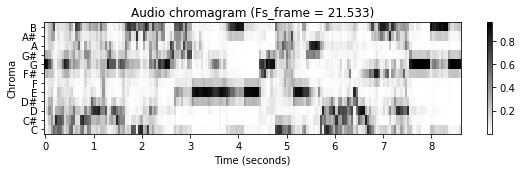

Sonification of audio chromagram (mono):


Sonification of audio chromagram and audio (stereo):


In [5]:
# Log-frequency spectrogram from audio recording
N = 2048
H = 1024
Fs_frame = Fs / H
C_wav = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
# C_wav = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=2)    
num_frames = C_wav.shape[1]

title = 'Audio chromagram (Fs_frame = %.3f)' % Fs_frame
libfmp.b.plot_chromagram(C_wav, Fs=Fs_frame, title=title, figsize=(8, 2.5))
plt.show()
x_chroma_wav, x_chroma_wav_stereo = libfmp.b.sonify_chromagram_with_signal(C_wav, x, Fs_frame, Fs)
print('Sonification of audio chromagram (mono):')
ipd.display(ipd.Audio(x_chroma_wav, rate=Fs) )
print('Sonification of audio chromagram and audio (stereo):')
ipd.display(ipd.Audio(x_chroma_wav_stereo, rate=Fs))
#libfmp.b.audio_player_list([x_chroma_wav, x_chroma_wav_stereo], [Fs, Fs], width=300, height=40, 
#            columns=['Chroma sonification (mono)', 'Chroma sonification and wav (stereo)'], column_align='left')

Similar to the case of the chromagram, one may derive a pitch-based feature representation directly from the music recordings.  Such representations are a special case of [log-frequency spectrograms](../C3/C3S1_SpecLogFreq-Chromagram.html), where the frequency axis is logarithmically spaced to from a pitch-based axis. This representation can be sonified similar to the piano-roll representation (using a sinusoidal model with harmonics), as demonstrated by the next code cell.

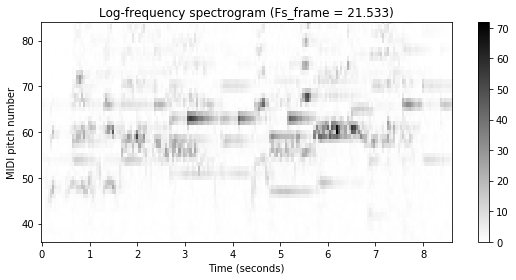

Sonification of log-frequency spectrogram (mono):


Sonification of log-frequency spectrogram and original audio (stereo):


In [6]:
# Log-frequency spectrogrm from audio recording
H = 1024
X_CQT = np.abs(librosa.cqt(y=x, sr=Fs, hop_length=H, norm=2))
num_frames = X_CQT.shape[1]
X_wav = np.zeros((128, num_frames))
X_wav[23:23+84, :] = X_CQT
#X = libfmp.c3.normalize_feature_sequence(X, norm='2')
Fs_frame = Fs / H
title='Log-frequency spectrogram (Fs_frame = %.3f)' % Fs_frame
libfmp.b.plot_matrix(X_wav, Fs=Fs_frame, ylabel='MIDI pitch number', 
                     title=title, figsize=(8, 4))
plt.ylim([36, 84])
plt.show()

# Sonification
harmonics = [1, 1/2, 1/3, 1/4, 1/5]
fading_msec = 0.5
x_pitch_wav, x_pitch_wav_stereo = \
    libfmp.b.sonify_pitch_activations_with_signal(X_wav, x, Fs_frame, Fs, 
                                                  fading_msec=fading_msec, 
                                                  harmonics_weights=harmonics)
print('Sonification of log-frequency spectrogram (mono):')
ipd.display(ipd.Audio(x_pitch_wav, rate=Fs) )
print('Sonification of log-frequency spectrogram and original audio (stereo):')
ipd.display(ipd.Audio(x_pitch_wav_stereo, rate=Fs))

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Tim Zunner.
</div>

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>